In [79]:
# Import dati dalla prof
from scipy.io import loadmat
import numpy as np
import scipy.linalg as spl
import RisolviSis as RS
import matplotlib.pyplot as plt
dati = loadmat('testF.mat')
A1 = dati["A"]
b1 = dati["b"]


# Equazioni Normali

In [80]:
# La risoluzione di un sistema sovradeterminato risulta essere un problema mal posto 
# in quanto potrebbe accadere che la soluzione non esista o non sia unica. Per
# renderlo ben posto lo si riformula come "risoluzione nel senso dei minimi quadrati"
# Definito un vettore residuo r(x) = Ax - b, cerchiamo una x* che rende minima 
# la norma 2 al quadrato del residuo.
def eqnorm(A, b):

    # Se la matrice A ha rango massimo ed è ben condizionata (condizione necessaria) 
    # possiamo procedere con il metodo delle equazioni normali: poniamo G = A.T @ A, 
    # matrice simmetrica che viene associata alla x che si vuole cercare andando
    # a definire una funzione F(x) per la quale il gradiente si annulli.
    # Questa nuova matrice sarà quadrata n x n con determinante diverso da 0.
    G = A.T @ A

    print("Indice di condizionamento di G ", np.linalg.cond(G))

    # Il problema descritto precedentemente si può risolvere facilmente grazie alla
    # risoluzione del seguente sistema lineare: G x = A.T b. Siccome G è simmetrica 
    # e definita positiva, il sistema può essere risolto utilizzando il metodo 
    # di Cholesky. In questo modo sono anche sicuro che il risultato ottenuto sia
    # un minimo della funzione F(x).
    f = A.T @ b
    L = spl.cholesky(G, lower=True)

    y, flag = RS.Lsolve(L, f)

    if (flag == 0):
        x, flag = RS.Usolve(L.T, y)

    return x


In [81]:
# La soluzione del problema dei minimi quadrati mediante equazioni normali richiede 
# solo che la matrice A del sistema sovradeterminato A x = b abbia rango massimo.
# L’idea è di individuare una trasformazione ortogonale che, applicata al residuo 
# r = Ax-b, lo trasformi in modo tale da rendere più facile la soluzione del problema 
# di minimizzarne la norma: le trasformazioni ortogonali lasciano inalterata la 
# norma 2 di un vettore.

""" sol = eqnorm(A1, b1)
print("Soluzione nel senso dei minimi quadrati:\n  ", sol)
print("Norma soluzione: ", np.linalg.norm(sol))

# Di quanto ci discostiamo dalla soluzione esatta?
x_esatta = np.ones_like(sol)
err = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)
print("Errore soluzione Eqnorm: ", err * 100) """

' sol = eqnorm(A1, b1)\nprint("Soluzione nel senso dei minimi quadrati:\n  ", sol)\nprint("Norma soluzione: ", np.linalg.norm(sol))\n\n# Di quanto ci discostiamo dalla soluzione esatta?\nx_esatta = np.ones_like(sol)\nerr = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)\nprint("Errore soluzione Eqnorm: ", err * 100) '

# QRLS

In [82]:
# La risoluzione di un sistema sovradeterminato risulta essere un problema mal posto 
# in quanto potrebbe accadere che la soluzione non esista o non sia unica. Per
# renderlo ben posto lo si riformula come "risoluzione nel senso dei minimi quadrati"
# Definito un vettore residuo r(x) = Ax - b, cerchiamo una x* che rende minima 
# la norma 2 al quadrato del residuo.
# Se A ha rango massimo ed è mediamente mal condizionata si può usare il metodo QR 
# per la soluzione del problema dei minimi quadrati, calcolando i due fattori Q 
# ed R di A, lavorando sempre solo sulla matrice A, senza dover passare alla matrice 
# A.T @ A che è molto più mal condizionata e sfruttando una fattorizzazione abbastanza
# stabile. Sotto queste condizioni il risultato sarà molto più preciao di altri metodi.
def QRLS(A, b):
    n = A.shape[1]
    Q, R = spl.qr(A)

    # Risolvo il sistema triangolare superiore: prime n righe e tutte le colonne
    # per avere una matrice quadrata
    h = Q.T @ b
    x, flag = RS.Usolve(R[0:n, :], h[0:n])
    residuo = np.linalg.norm(h[n:])**2

    return x, residuo


In [83]:
sol, residuo = QRLS(A1, b1)
print("Soluzione nel senso dei minimi quadrati:\n  ", sol)
print("Residuo: ", residuo)
print("Norma soluzione: ", np.linalg.norm(sol))

# Di quanto ci discostiamo dalla soluzione esatta?
x_esatta = np.ones_like(sol)
err = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)
print("Errore soluzione QRLS: ", err * 100)


Soluzione nel senso dei minimi quadrati:
   [[ 3.91654082]
 [17.67757482]
 [45.88259896]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 0.91314752]
 [-2.41741615]
 [-0.74804675]
 [ 3.33577455]]
Residuo:  4.302410399220467e-27
Norma soluzione:  49.63278690438052
Errore soluzione QRLS:  1105.3204318277503


# SVDLS

In [84]:
# La risoluzione di un sistema sovradeterminato risulta essere un problema mal posto 
# in quanto potrebbe accadere che la soluzione non esista o non sia unica. Per
# renderlo ben posto lo si riformula come "risoluzione nel senso dei minimi quadrati"
# Definito un vettore residuo r(x) = Ax - b, cerchiamo una x* che rende minima 
# la norma 2 al quadrato del residuo.
# Se A non ha rango massimo si sfrutta il metodo di decomposizione ai valori singolari,
# secondo il quale la matrice A viene decomposto in due vettori U e V.T detti rispettivamente
# vettori singolari sinistri e destri per cui valgono le seguenti proprietà:
# - tutti i valori singolari sono reali >= 0
# - il rapporto tra il massimo e il minimo dei singolari ci dà l'indice di condizionamento
#   di A
# - i valori singolari non nulli ci dicono quale é il rango di A.
# - il primo dei valori singolari é sempre il massimo.
def SVDLS(A, b):
    n = A.shape[1]  # numero di colonne di A
    m = A.shape[0]  # numero di righe
    
    # La decomposizione di A
    U, s, V_T = spl.svd(A)
    V = V_T.T

    # Calcolo del rango della matrice, numero dei valori singolari maggiori di una soglia
    thresh = np.spacing(1) * m * s[0]
    k = np.count_nonzero(s > thresh)

    # Controllo sul rango
    print("Rango: ", k)
    if (k < n):
        print("La matrice non è a rango massimo")
    else:
        print("La matrice è a rango massimo")

    # La condizione aggiuntiva che inseriamo per risolvere il problema dei minimi
    # quadrati: minimizzo il residuo cercando una soluzione fra le infinite di
    # norma minima.
    d = U.T @ b
    d1 = d[:k].reshape(k, 1)
    s1 = s[:k].reshape(k, 1)
    # Risolve il sistema diagonale di dimensione kxk avene come matrice dei 
    # coefficienti la matrice Sigma.
    c = d1/s1
    x = V[:, :k] @ c
    residuo = np.linalg.norm(d[k:])**2
    return x, residuo


In [85]:
sol, residuo = SVDLS(A1, b1)
print("Soluzione nel senso dei minimi quadrati:\n  ", sol)
print("Residuo: ", residuo)
print("Norma soluzione: ", np.linalg.norm(sol))

# Di quanto ci discostiamo dalla soluzione esatta?
x_esatta = np.ones_like(sol)
err = np.linalg.norm(sol - x_esatta) / np.linalg.norm(x_esatta)
print("Errore soluzione SVDLS: ", err * 100)


Rango:  15
La matrice non è a rango massimo
Soluzione nel senso dei minimi quadrati:
   [[ 8.93308674e-01]
 [ 5.99593662e-02]
 [-1.00818890e-04]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.08594726e+00]
 [ 1.16319260e+00]
 [ 9.47694272e-01]
 [ 9.09857191e-01]]
Residuo:  8.36982653034658e-27
Norma soluzione:  4.130358162106173
Errore soluzione SVDLS:  31.955079101458395


# Approssimazione ai minimi quadrati

Rango:  3
La matrice è a rango massimo
Residuo:  0.06766884146211058


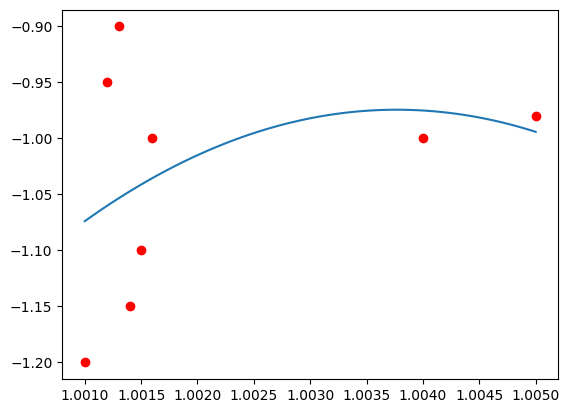

Errore:  0.06766884146655766


In [86]:
# Dati due vettori di m dati sperimentali che descrivono l'andamento di un fenomeno reale,
# si cerca un polinomio di grado n i cui coefficienti sono ottenuti tramite la risoluzione
# del problema dei minimi quadrati.
#
x = np.array([1.001, 1.004, 1.005, 1.0012,
                1.0013,   1.0014,   1.0015,  1.0016])
y = np.array([-1.2, -1.0, -0.98, -0.95, 
                -0.9, -1.15, -1.1, -1])
m = x.shape[0]
n = 2  # grado del polinomio di regressione
n1 = n + 1  # gradi di libertà
A = np.vander(x, increasing=True)[:, :n1]
alpha, residuo = SVDLS(A, y)
#alpha = eqnorm(A, y)

print("Residuo: ", residuo)
xv = np.linspace(np.min(x), np.max(x), 100)
pol1 = np.polyval(np.flip(alpha), xv)
plt.plot(xv, pol1, x, y, 'ro')
plt.show()
errore = np.linalg.norm(y - np.polyval(np.flip(alpha), x))**2
print("Errore: ", errore)


# Retta di regressione

Condizionamento di A: 4.663457775986456
Indice di condizionamento di G  21.747838428408542


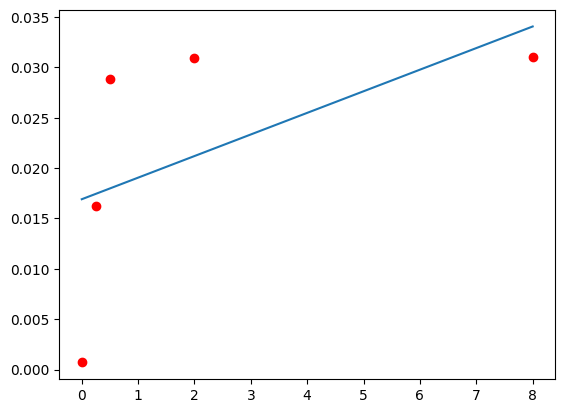

Errore:  0.0004848327762313228
Condizionamento di A:  65.67493525624785


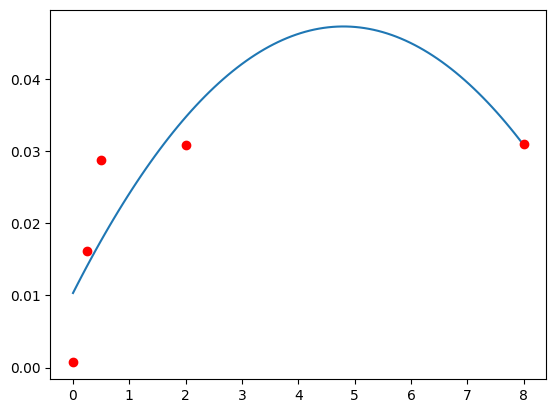

Residuo:  0.00023646355940249873
Condizionamento di A:  356547027314.2508
Indice di condizionamento di G  1.4095605216900414e+20
Errore eqn 0.0018066609384609072
Errore qr 0.0001793601626948677
Rango:  5
La matrice è a rango massimo
Errore svd 0.0001793602362690831


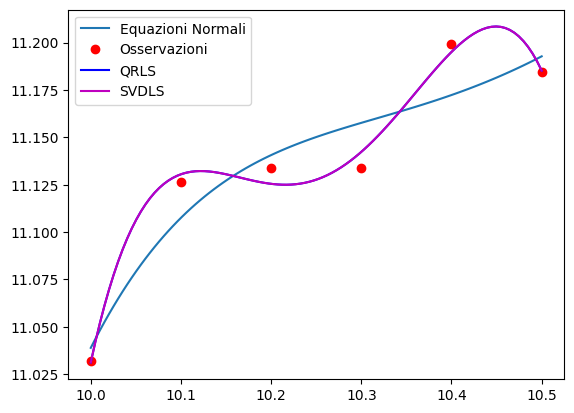

Condizionamento di A:  356547027314.2508
Indice di condizionamento di G  1.4095605216900414e+20
Errore eqn 0.0018066609384609072
Errore qr 0.0001793601626948677
Rango:  5
La matrice è a rango massimo
Errore svd 0.0001793602362690831


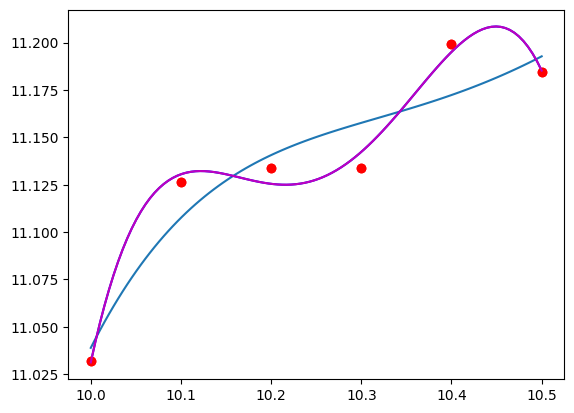

In [87]:
x = np.array([0.0004, 0.2507, 0.5008, 2.0007, 8.0013])
y = np.array([0.0007, 0.0162, 0.0288, 0.0309, 0.0310])
m = x.shape[0]
n = 1  # retta di regressione: grado 1
n1 = n+1  # gradi di libertà
A = np.vander(x, increasing=True)[:, :n1]
condA = np.linalg.cond(A)
print("Condizionamento di A:", condA)
# Poichè la matrice A è ben condizionata uso il metodo delle equazioni normali,
# la matrice G=A.T@A avrà un indice di condizionamento K(A)^2 contenuto
alpha2 = eqnorm(A, y)
xv = np.linspace(np.min(x), np.max(x), 100)
pol2 = np.polyval(np.flip(alpha2), xv)
plt.plot(xv, pol2, x, y, 'ro')
plt.show()
errore = np.linalg.norm(y - np.polyval(np.flip(alpha2), x))**2
print("Errore: ", errore)

n = 2  # parabola di regressione: grado 2
n1 = n + 1  # gradi di libertà
A = np.vander(x, increasing=True)[:, :n1]
condA = np.linalg.cond(A)
print("Condizionamento di A: ", condA)
# Poichè la matrice è mediamente ben condizionata (Ha un indice di condizionamento pari a  65.67493525624782
# (quinfi A.T@A avrà indice di condizionamento pari al quadrato dell'indice di condionamento di A)
# è quindi preferibile usare il metodo QR
alpha2, residuo = qrLS(A, y)
xv = np.linspace(np.min(x), np.max(x), 100)
pol2 = np.polyval(np.flip(alpha2), xv)
plt.plot(xv, pol2, x, y, 'ro')
plt.show()
print("Residuo: ", residuo)


x = np.arange(10, 10.6, 0.5/5)
y = np.array([11.0320, 11.1263, 11.1339, 11.1339, 11.1993, 11.1844])
n = 4  # grado del polinomio di regressione: 4
n1 = n + 1  # gradi di libertà
A = np.vander(x, increasing=True)[:, :n1]
condA = np.linalg.cond(A)
print("Condizionamento di A: ", condA)

alpha3_eqn = eqnorm(A, y)
xv = np.linspace(np.min(x), np.max(x), 100)
pol3_eqn = np.polyval(np.flip(alpha3_eqn), xv)
plt.plot(xv, pol3_eqn, x, y, 'ro')
errore_eqn = np.linalg.norm(y - np.polyval(np.flip(alpha3_eqn), x))**2
print("Errore eqn", errore_eqn)

alpha3_qr, residuo_qr = qrLS(A, y)
pol3_qr = np.polyval(np.flip(alpha3_qr), xv)
plt.plot(xv, pol3_qr, 'b')
print("Errore qr", residuo_qr)

alpha3_svd, residuo_svd = SVDLS(A, y)
pol3_svd = np.polyval(np.flip(alpha3_svd), xv)
print("Errore svd", residuo_svd)
plt.plot(xv, pol3_svd, 'm')

# A causa dell'elevato mal condizionamento di G il metodo delle
# equazioni normali non approssima i dati in maniera accurata
# (errore maggiore rispetto agli altri due metodi, che forniscono
# la stess accuratezza (grafici sovrapposti))
plt.legend(['Equazioni Normali', 'Osservazioni', 'QRLS', 'SVDLS'])
plt.show()

# E se applico delle perturbazioni?
# Ricalcolo il polimonio di grado 4 a partire da dati perturbati come richiesto dall'esercizio
xp = x.copy()
#xp[1] = xp[1] + 0.013
yp = y.copy()
#yp[1] = yp[1] - 0.001

n = 4  # grado del polinomio di regressione: 4
n1 = n + 1  # gradi di libertà
A = np.vander(xp, increasing=True)[:, :n1]
condA = np.linalg.cond(A)
print("Condizionamento di A: ", condA)

alpha3_eqn = eqnorm(A, yp)
xv = np.linspace(np.min(x), np.max(x), 100)
pol3_eqn = np.polyval(np.flip(alpha3_eqn), xv)
plt.plot(xv, pol3_eqn, x, y, 'ro')
errore_eqn = np.linalg.norm(y - np.polyval(np.flip(alpha3_eqn), x))**2
print("Errore eqn", errore_eqn)

alpha3_qr, residuo_qr = qrLS(A, yp)
pol3_qr = np.polyval(np.flip(alpha3_qr), xv)
plt.plot(xv, pol3_qr, 'b', xp, yp, 'ro')
print("Errore qr", residuo_qr)

alpha3_svd, residuo_svd = SVDLS(A, y)
pol3_svd = np.polyval(np.flip(alpha3_svd), xv)
print("Errore svd", residuo_svd)
plt.plot(xv, pol3_svd, 'm')


# Funzioni e Approssimazioni di dati sperimentali

Rango:  3
La matrice è a rango massimo
Norma 2 al quadrato dell'errore  36.698412698412724


(-1.0609720865369214,
 6.681792039720546,
 -0.9948852973555004,
 6.748853551323754)

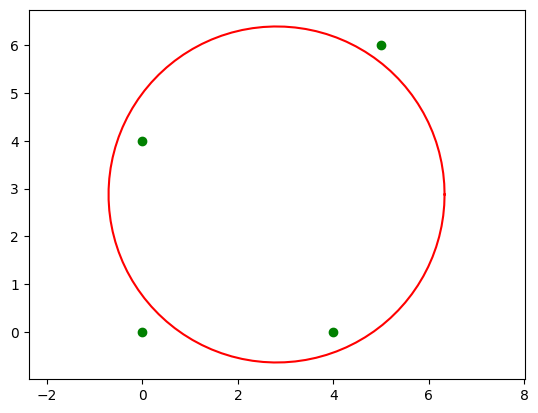

In [88]:
import math
px = np.array([0, 4, 0, 5])
py = np.array([0, 0, 4, 6])
# Costruisco il sistema lineare sovradeterminato come richiesto
A = np.array([[0, 0, 1], [4, 0, 1], [0, 4, 1], [5, 6, 1]])
b = np.array([[0], [-16], [-16], [-61]])

a, err = SVDLS(A, b)
print("Norma 2 al quadrato dell'errore ", err)
# Calcolo il centro
cx = -a[0]/2
cy = -a[1]/2
# Calcolo il raggio con la formula data
r1 = math.sqrt((a[0]**2)/4+(a[1]**2)/4-a[2])
t = np.linspace(0, 2*math.pi, 100)
# Costruisco le due componenti parametriche della circonferemza
x = cx+r1*np.cos(t)
y = cy+r1*np.sin(t)
plt.plot(x, y, 'r-')
plt.plot(px, py, 'go')
plt.axis('equal')


Rango di ----> 3
Con Condizionamento M -->  18.45808953019451
Rango di A1 ---> 2
Condizionamento di A1--->  4.663457775986456
Indice di condizionamento di G  21.747838428408542
Rango di A2 3
Condizionamento di A2  65.67493525624785
quadrato residuo exp 1.2249733128901832e-05
quadrato residuo pol grado 2  0.00023646355940249873


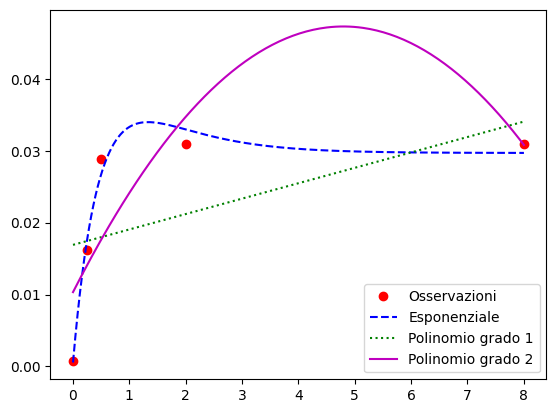

In [89]:
m = 5
x4 = np.array([0.0004, 0.2507, 0.5008, 2.0007, 8.0013])
y4 = np.array([0.0007, 0.0162, 0.0288, 0.0309, 0.0310])
M = np.zeros((5, 3))
M[:, 0] = np.ones((5,))
M[:, 1] = np.exp(-x4)
M[:, 2] = np.exp(-2*x4)

print('Rango di M ---->', np.linalg.matrix_rank(M))
print("Con Condizionamento M --> ", np.linalg.cond(M))
# La matrice M è a rango massimo, ha condizionamento 18.45, quindi la marice G delle equazioni
# normali (di dimensioni 4x4) avrebbe indice
# di condizionamento circa 343. Utilizzo il metodo
aexp, resexp = qrLS(M, y4)

xx = np.linspace(np.min(x4), np.max(x4), 200)
polexp = aexp[0]+aexp[1]*np.exp(-xx)+aexp[2]*np.exp(-2*xx)

# Calcolo del polinomio approssimante di grado 1
n = 1
n1 = n+1
A1 = np.vander(x4, increasing=True)[:, :n1]
print('Rango di A1 --->', np.linalg.matrix_rank(A1))
print("Condizionamento di A1---> ", np.linalg.cond(A1))
# Matrice a rango massimo e ben condizionata: uso le equazioni normali
alpha1 = eqnorm(A1, y4)
pol1 = np.polyval(np.flip(alpha1), xx)

# Parabola approssimante
n = 2
n1 = n+1
A2 = np.vander(x4, increasing=True)[:, :n1]
print('Rango di A2', np.linalg.matrix_rank(A2))
print("Condizionamento di A2 ", np.linalg.cond(A2))
# Matrice a rango massimo e mediamente mal condizionata: uso qr
alpha2, res2 = qrLS(A2, y4)
pol2 = np.polyval(np.flip(alpha2), xx)
print("quadrato residuo exp", resexp)
print("quadrato residuo pol grado 2 ", res2)

plt.plot(x4, y4, 'ro', xx, polexp, 'b--', xx, pol1, 'g:', xx, pol2, 'm-')
plt.legend(['Osservazioni', 'Esponenziale',
           'Polinomio grado 1', 'Polinomio grado 2'])
